# NER with Bidirectional-LSTM-CNNs

The original paper can be found at https://arxiv.org/abs/1511.08308

In [1]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
!pip install konlpy

In [3]:
!pip install gensim

In [4]:
import numpy as np
print(np.__version__)

1.16.5


In [6]:
#colab에서 실행 중이라면...
!git clone https://github.com/hukim1112/comment_classifier.git
import os
os.chdir('/content/comment_classifier')

Cloning into 'comment_classifier'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 62 (delta 15), reused 55 (delta 8), pack-reused 0
Unpacking objects: 100% (62/62), done.
Checking out files: 100% (34/34), done.


In [0]:
# ner.py 수정
# allow_pickle=True

# Entitiy Folder 생성
# 경로 변경

In [7]:
import tensorflow as tf
from konlpy.tag import Twitter
from collections import Counter
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from data_utils import createBatches, iterate_minibatches
import ner
keras = tf.keras
t = Twitter()

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


# 1. read train dataset

In [0]:
file_path = 'train_entity.csv'

In [0]:
with open(file_path, encoding='euc-kr') as f:
    tokenized_sentences, labels = [], []
    tokenized_sentence, label = [], []
    for line in f:
        line = line.strip()
        if (len(line) == 0 or line.startswith("-DOCSTART-")):
            if not len(tokenized_sentence) == 0:
                tokenized_sentences.append(tokenized_sentence)
                labels.append(label)
                tokenized_sentence, label = [], [] #초기화
        else:
            word, tag = line.split(' ')
            tokenized_sentence.append(word)
            label.append(tag)

In [10]:
tokenized_sentences[:20]

[['다음', '주', '전주', '비', '오려나'],
 ['이번', '주', '서울', '눈', '오니'],
 ['이번', '주', '대구', '날씨', '비', '오는지', '알려줘'],
 ['부산', '이번', '주', '날씨', '맑은지', '알려줄래'],
 ['광주', '이번', '주', '눈', '오려나'],
 ['울산', '이번', '주', '비', '오니'],
 ['이번', '주', '인천', '날씨', '눈', '오니'],
 ['이번', '주', '전주', '비', '오는지', '알려줄래'],
 ['이번', '주', '강릉', '맑아'],
 ['이번', '주', '속초', '날씨', '맑니'],
 ['이번', '주', '과천', '눈', '오니'],
 ['이번', '주', '군산', '비', '오니'],
 ['다음', '주', '전주', '날씨', '알려줘'],
 ['이번', '주', '서울', '날씨', '알려줘'],
 ['이번', '주', '대구', '날씨', '알려줘'],
 ['이번', '주', '부산', '날씨', '알려줘'],
 ['이번', '주', '광주', '날씨', '알려줘'],
 ['이번', '주', '울산', '날씨', '알려줘'],
 ['이번', '주', '인천', '날씨', '알려줘'],
 ['이번', '주', '전주', '날씨', '알려줘']]

# 2. Get vectorizer and fix some data error

In [0]:
from vectorizer import BaseVectorizer
vectorizer = BaseVectorizer(t.morphs)

In [12]:
print("tokenized sentence : ", tokenized_sentences[1606], '\n',
      "labels : ", labels[1606])

tokenized sentence :  ['모레', '송파구', '날씨', '알려줘'] 
 labels :  ['DATE', 'LOCATION', 'O', 'O']


In [13]:
vectorizer.tokenizer('말해줄래') #우리 tokenizer와 다른 형태소 분석 형태로 데이터가 구성되어 있음.

['말', '해줄래']

In [0]:
for ts, label in zip(tokenized_sentences, labels):
    for idx, word in enumerate(ts):
        if len(vectorizer.tokenizer(word))>1:
            tokenized_word = vectorizer.tokenizer(word)
            ts.pop(idx)
            tag = label.pop(idx)
            for i in tokenized_word[::-1]:
                ts.insert(idx, i)
                label.insert(idx, tag)

In [15]:
tokenized_sentences[1606]

['모레', '송파구', '날씨', '알려줘']

In [16]:
labels[1606]

['DATE', 'LOCATION', 'O', 'O']

# 3. Create word vocabulary and char vocabulary

In [0]:
sentences = []
for ts in tokenized_sentences:
    sentence = ' '.join(ts)
    sentences.append(sentence)

In [18]:
vectorizer.fit(sentences) #create word vocabulary from docs

scanning was done                                        
535 terms are recognized


In [0]:
vectorizer.get_char2idx() 
#create dictionary for converting char into index

In [20]:
print(vectorizer.char2idx)

{'_PAD_': 0, '_UNK_': 1, '_': 2, 'P': 3, 'A': 4, 'D': 5, 'U': 6, 'N': 7, 'K': 8, 'S': 9, 'T': 10, 'E': 11, 'O': 12, '날': 13, '씨': 14, '우': 15, '산': 16, '하': 17, '니': 18, '내': 19, '일': 20, '오': 21, '늘': 22, '써': 23, '야': 24, '주': 25, '알': 26, '려': 27, '줘': 28, '이': 29, '번': 30, '모': 31, '레': 32, '말': 33, '줄': 34, '래': 35, '마': 36, '스': 37, '크': 38, '비': 39, '챙': 40, '길': 41, '까': 42, '해': 43, '세': 44, '요': 45, '울': 46, '옷': 47, '입': 48, '을': 49, '어': 50, '상': 51, '태': 52, '전': 53, '서': 54, '쓸': 55, '부': 56, '광': 57, '떠': 58, '뭐': 59, '공': 60, '기': 61, '눈': 62, '북': 63, '지': 64, '좀': 65, '인': 66, '천': 67, '군': 68, '좋': 69, '쓰': 70, '고': 71, '민': 72, '다': 73, '음': 74, '돼': 75, '겨': 76, '때': 77, '나': 78, '뭔': 79, '맑': 80, '있': 81, '양': 82, '대': 83, '구': 84, '라': 85, '바': 86, '람': 87, '강': 88, '릉': 89, '경': 90, '도': 91, '원': 92, '포': 93, '싫': 94, '은': 95, '데': 96, '는': 97, '수': 98, '아': 99, '남': 100, '시': 101, '충': 102, '청': 103, '떤': 104, '미': 105, '먼': 106, '속': 107, '초': 108, '과': 109, '

In [0]:
label2idx = {}
idx2label = []
for label in labels:
    for l in label:
        if l not in label2idx:
            label2idx[l] = len(label2idx)
            idx2label.append(l)

In [22]:
print(label2idx, idx2label)

{'DATE': 0, 'LOCATION': 1, 'O': 2} ['DATE', 'LOCATION', 'O']


# 4. Prepare dataset for training

In [0]:
MAX_LENGTH = 15

def padding_char_indice(char_indice, MAX_LENGTH):
    return tf.keras.preprocessing.sequence.pad_sequences(
      char_indice, maxlen=MAX_LENGTH, padding='post', 
      value = vectorizer.char2idx['_PAD_'])
    

def integer_coding(tokenized_sentences, labels):
    dataset = []
    for ts, label in zip(tokenized_sentences, labels):
        word_indice = [vectorizer.vocabulary_[t] for t in ts]
        char_indice = [[vectorizer.char2idx[char] for char in t]  
                                                     for t in ts]
        char_indice = padding_char_indice(char_indice, MAX_LENGTH)
        label_indice = [label2idx[l] for l in label]
    
        for chars_of_token in char_indice:
            if len(chars_of_token)>MAX_LENGTH:
                print("최대 단어 길이 초과!")
                continue
        dataset.append([word_indice, char_indice, label_indice])
    return dataset

In [0]:
dataset = integer_coding(tokenized_sentences, labels)

In [0]:
word_indice, char_indice, label_indice = dataset[0]

In [26]:
word_indice

[49, 10, 27, 17, 55]

In [27]:
vectorizer.decode_from_list(word_indice)

['다음', '주', '전주', '비', '오려나']

In [28]:
label_indice

[0, 0, 1, 2, 2]

In [29]:
[idx2label[l] for l in label_indice]

['DATE', 'DATE', 'LOCATION', 'O', 'O']

In [30]:
char_indice

array([[73, 74,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [53, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [21, 27, 78,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int32)

### save vocabularies

In [0]:
import os
os.makedirs("./Entity", exist_ok=True)
np.save("Entity/idx2Label.npy",idx2label)
np.save("Entity/word2Idx.npy",vectorizer.vocabulary_)
np.save("Entity/char2Idx.npy",vectorizer.char2idx)

# 5. Training

In [0]:
train_batch,train_batch_len = createBatches(dataset)

In [33]:
for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens ,char = batch
        print(tokens.shape)

(86, 2)
(637, 3)
(1043, 4)
(1509, 5)
(399, 6)
(157, 7)
(14, 8)
(4, 9)
(2, 24)


In [0]:
from tensorflow.keras.layers import Embedding, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.utils import Progbar

In [35]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=len(vectorizer.vocabulary_), output_dim=64)(words_input)
character_input=Input(shape=(None,MAX_LENGTH,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(vectorizer.char2idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(MAX_LENGTH))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)
output = concatenate([words, char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label2idx), activation='softmax'))(output)
model = Model(inputs=[words_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 15, 30) 7050        char_input[0][0]                 
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 15, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 15, 30) 2730        dropout[0][0]                    
______________________________________________________________________________________________

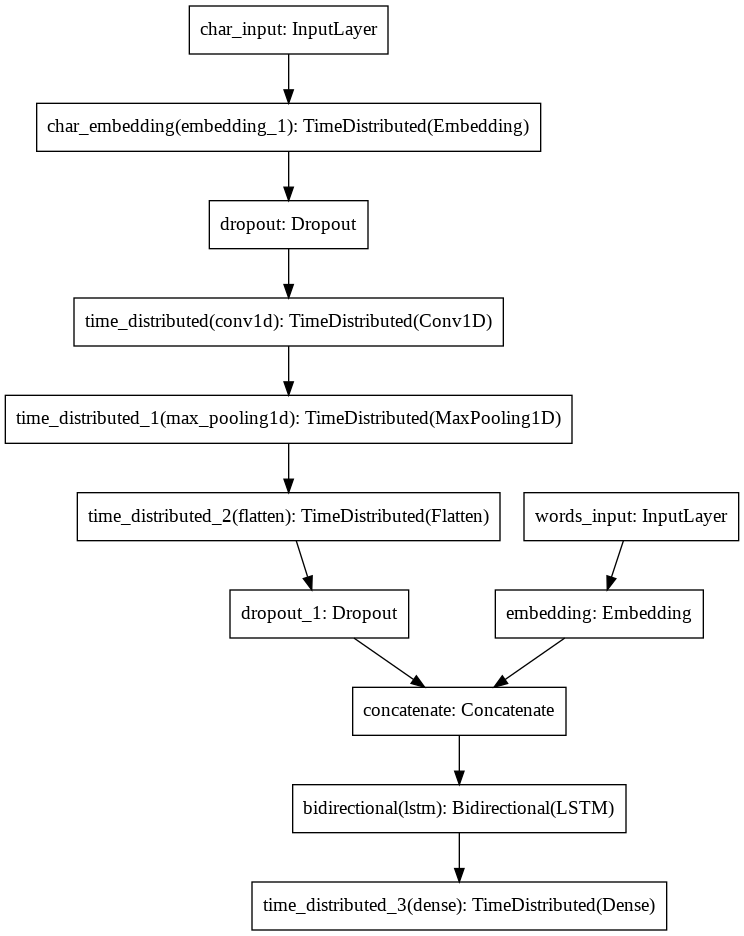

In [36]:
tf.keras.utils.plot_model(model, 'model.png')

In [37]:
epochs = 20

for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens, char = batch       
        model.train_on_batch([tokens, char], labels)
        a.update(i)
    a.update(i+1)
    print(' ')

Epoch 0/20
9/9 [==============================] - 4s 479ms/step
 
Epoch 1/20
9/9 [==============================] - 4s 467ms/step
 
Epoch 2/20
9/9 [==============================] - 4s 477ms/step
 
Epoch 3/20
9/9 [==============================] - 4s 472ms/step
 
Epoch 4/20
9/9 [==============================] - 4s 466ms/step
 
Epoch 5/20
9/9 [==============================] - 4s 434ms/step
 
Epoch 6/20
9/9 [==============================] - 4s 431ms/step
 
Epoch 7/20
9/9 [==============================] - 4s 447ms/step
 
Epoch 8/20
9/9 [==============================] - 4s 428ms/step
 
Epoch 9/20
9/9 [==============================] - 4s 437ms/step
 
Epoch 10/20
9/9 [==============================] - 4s 437ms/step
 
Epoch 11/20
9/9 [==============================] - 4s 437ms/step
 
Epoch 12/20
9/9 [==============================] - 4s 439ms/step
 
Epoch 13/20
9/9 [==============================] - 4s 443ms/step
 
Epoch 14/20
9/9 [==============================] - 4s 441ms/step
 
Epoch

In [0]:
model.save("Entity/model.h5")

# 6. Prediction

In [0]:
ner_parser = ner.Parser(t.morphs)
ner_parser.load_models()

In [40]:
ner_parser.predict('내일 부산 날씨는?')

[('내일', 'DATE'), ('부산', 'LOCATION'), ('날씨', 'O'), ('는', 'O'), ('?', 'O')]

In [41]:
ner_parser.predict('오늘 서울 날씨 어때?')

[('오늘', 'DATE'), ('서울', 'LOCATION'), ('날씨', 'O'), ('어때', 'O'), ('?', 'O')]

In [42]:
ner_parser.predict('9월 15일 수유동 날씨 궁금해')

[('9월', 'DATE'),
 ('15일', 'DATE'),
 ('수유동', 'LOCATION'),
 ('날씨', 'O'),
 ('궁금해', 'O')]